# Identifying Win or Loss of League of Legends Games at the 10 Minute Marker

League of Legends is an extremely competitive game and currently dominates the esports scene, bringing in 1.2 million peak viewers, which is more than double that of esports' second most viewed game Minecraft, with 516 thousand peak viewers. "High-elo" games are those in which the best players compete to further increase their rank. As the competition increases towards the top of the rank scoreboard, these games are won or loss at a much faster pace, with the highest rank, Challenger, averaging a duration of 4 minutes less than the lowest rank. Therefore, one could posit that the initial moves of higher ranked elo games are characteristically more important to the win or loss of the game. This analysis serves to build a model that can classify the win or loss of a game by the game stats at the 10 minute mark. This is 19 minutes before the average end of game time at the highest elo.

### Data Preprocessing

In [67]:
# Imports
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [44]:
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),"train Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}

In [68]:
def plot_decision_tree(model, feature_names):
    plt.subplots(figsize=(25, 20))
    tree.plot_tree(model, feature_names=feature_names, filled=True)
    plt.show()

In [2]:
# Download dataset
# od.download("https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min")

In [3]:
# Read csv file into pandas dataframe
data = pd.read_csv('league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv')

In [4]:
# Examing head of data file
data.head(10)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
5,4475365709,1,18,0,0,5,3,6,1,1,...,0,15201,7.0,18060,221,59,-698,-101,22.1,1520.1
6,4493010632,1,18,3,1,7,6,7,1,1,...,0,14463,6.4,15404,164,35,-2411,-1563,16.4,1446.3
7,4496759358,0,16,2,0,5,13,3,0,0,...,0,17920,6.6,16938,157,54,2615,800,15.7,1792.0
8,4443048030,0,16,3,0,7,7,8,0,0,...,0,18380,7.2,19298,240,53,1979,771,24.0,1838.0
9,4509433346,1,13,1,1,4,5,5,1,1,...,0,16605,6.8,18379,247,43,1548,1574,24.7,1660.5


In [5]:
# Make sure all rows are unique games by their id
data.loc[:,'gameId'].unique().size == data.shape[0]

True

In [6]:
# View all columns
print(data.columns)

Index(['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')


In [29]:
# Check for missing values
null_values = data.isnull().sum()
for column in null_values.index:
    if null_values[column] != 0:
        print(f"Null values in {column}")

Here I remove some columns when splitting into features and target
1. **redGoldDiff** because it is -1 * 'blueGoldDiff'
2. **redGoldPerMin** because it is 'redTotalGold' / 10
3. **blueGoldPerMin** because it is 'blueTotalGold' / 10
4. **blueAvgLevel** because it is a division of 'blueTotalExperience'
5. **redAvgLevel** because it is a division of 'redTotalExperience'
6. **gameId** because every gameId is unique

In [7]:
# Split data into features and target
feature_cols = [x for x in data.columns if x != 'redGoldDiff' and x != 'redGoldPerMin' and x != 'blueGoldPerMin' and
               x != 'blueAvgLevel' and x != 'redAvgLevel' and x != 'gameId' and x != 'blueWins']
X = data.loc[:, feature_cols]
y = data.loc[:, 'blueWins']

In [8]:
# Check that all data types are numerical
obj_cols = [x for x in X.dtypes if x == object]
print(len(obj_cols))
print(y.dtypes == object)

0
False


In [9]:
# Check for how many target classes there are (should be just two, 1 for blue wins, 0 for red wins)
y.nunique()

2

In [10]:
# Check for balance of the classes
y.value_counts()

blueWins
0    4949
1    4930
Name: count, dtype: int64

In [17]:
# Train test split
rs = 333
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
print(X_train.shape[0] / X.shape[0])
X_train.head()

0.6999696325539022


,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,...,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redExperienceDiff,redCSPerMin
8530,18,1,0,7,5,2,0,0,0,0,...,2,1,1,0,15386,16849,180,44,-582,18.0
4314,39,2,1,4,4,6,1,1,0,0,...,0,0,0,0,15650,17868,222,45,97,22.2
7418,17,2,1,7,3,8,0,0,0,0,...,0,0,0,0,14425,16373,212,41,-1235,21.2
3277,16,5,1,3,7,5,0,0,0,0,...,2,1,1,0,16993,19367,242,59,1813,24.2
6036,12,2,0,7,11,4,0,0,0,0,...,0,0,0,0,19074,19125,238,65,1919,23.8


### Model Selection and Training

In [52]:
bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion="entropy", max_depth = 4,random_state=rs), n_estimators=30, random_state=rs, bootstrap=True)

In [53]:
bag.fit(X_train, y_train)

C:\Users\dylan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=4,
                                                        random_state=333),
                  n_estimators=30, random_state=333)

In [54]:
get_accuracy(X_train, X_test, y_train, y_test, bag)

{'test Accuracy': 0.7277327935222672, 'train Accuracy': 0.7369486623282718}

In [51]:
s = StandardScaler()
X_train_s = s.fit_transform(X_train)
X_test_s = s.transform(X_test)

In [55]:
param_grid = {
    'base_estimator': [DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=rs),
                       SVC(C=10.0, max_iter=10000),
                       KNeighborsClassifier(n_jobs=-1)],
    'n_estimators': [10, 30, 50, 100],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(BaggingClassifier(random_state=rs), param_grid=param_grid, cv=3, n_jobs=-1) 

In [56]:
grid_search.fit(X_train, y_train)

C:\Users\dylan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


GridSearchCV(cv=3, estimator=BaggingClassifier(random_state=333), n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeClassifier(criterion='entropy',
                                                                   max_depth=4,
                                                                   random_state=333),
                                            SVC(C=10.0, max_iter=10000),
                                            KNeighborsClassifier(n_jobs=-1)],
                         'bootstrap': [True, False],
                         'n_estimators': [10, 30, 50, 100]})

In [58]:
grid_search.best_params_

{'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=333),
 'bootstrap': True,
 'n_estimators': 50}

In [59]:
grid_search.best_score_

0.7272595806218366

Bagging with a decision tree classifier with 50 estimators gave the best score of 73% mean accuracy

In [63]:
param_grid = {
    'base_estimator__max_depth': [4, 5, 7, 10],
    'base_estimator__criterion': ['gini', 'entropy', 'log_loss'],
    'base_estimator__max_features': [None, 'sqrt', 'log2']
}
bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=rs), n_estimators=50, random_state=rs, bootstrap=True)
grid_search = GridSearchCV(bag, param_grid=param_grid, cv=3, n_jobs=-1)

In [64]:
grid_search.fit(X_train, y_train)

C:\Users\dylan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=333),
                                         n_estimators=50, random_state=333),
             n_jobs=-1,
             param_grid={'base_estimator__criterion': ['gini', 'entropy',
                                                       'log_loss'],
                         'base_estimator__max_depth': [4, 5, 7, 10],
                         'base_estimator__max_features': [None, 'sqrt',
                                                          'log2']})

In [65]:
grid_search.best_params_

{'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 7,
 'base_estimator__max_features': 'sqrt'}

In [73]:
grid_search.best_score_

0.7307302964569775

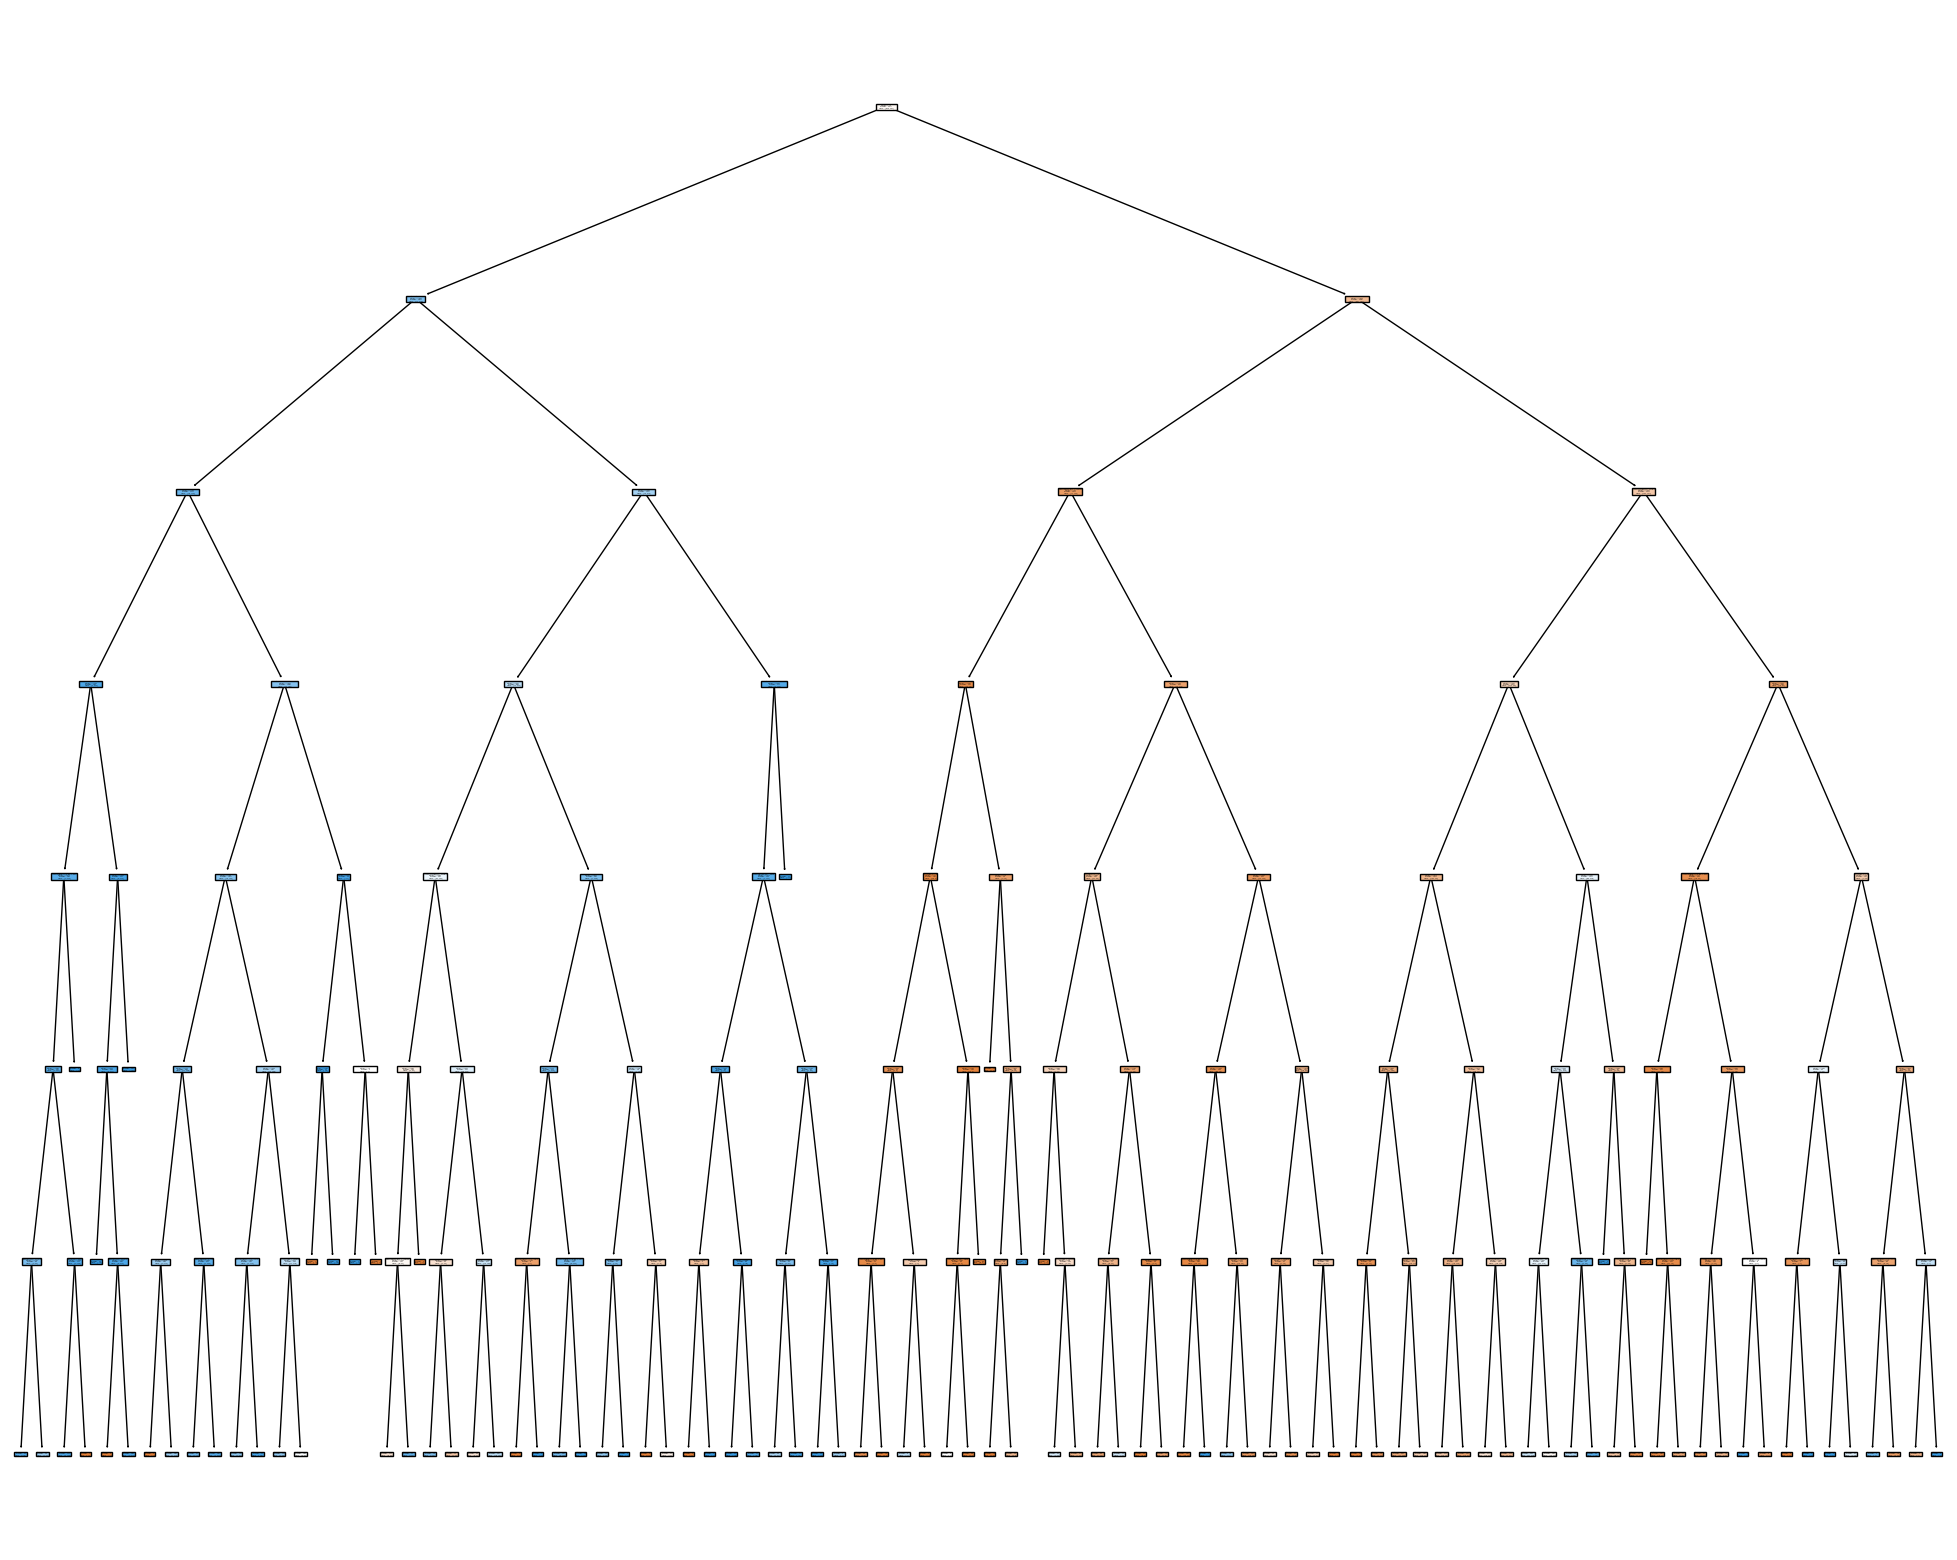

In [72]:
feature_cols = X_train.columns.values
best_tree = grid_search.best_estimator_.estimator_
best_tree.fit(X_train, y_train)
plot_decision_tree(best_tree, feature_cols)